In [98]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

from tqdm import tqdm_notebook as tqdm


# Feature Engineering

In [99]:
df = pd.read_json('data/data_features.json', lines= True)
df.columns

Index(['distance_mrt', 'town', 'flat_num', 'age_transation', 'lease_commence',
       'transaction_yr', 'transaction', 'storey_height', 'resale_price',
       'resale_price_adj', 'Postal', 'Location'],
      dtype='object')

In [100]:
columns = ['distance_mrt','age_transation','transaction_yr','Postal','storey_height', 'resale_price_adj','town','flat_num']

df_chosen = df[columns].copy()
df_chosen = df_chosen[df_chosen['Postal']!='NIL'] #remove the items with no postal code#
df_chosen['Postal'] = df_chosen['Postal'].astype(int)  #convert to int

print(df_chosen.shape[0], 'filtered out of:', df.shape[0])
df_chosen.columns

129045 filtered out of: 129809


Index(['distance_mrt', 'age_transation', 'transaction_yr', 'Postal',
       'storey_height', 'resale_price_adj', 'town', 'flat_num'],
      dtype='object')

In [101]:
df_chosen.isna().sum()  #confirm no NA values

distance_mrt        0
age_transation      0
transaction_yr      0
Postal              0
storey_height       0
resale_price_adj    0
town                0
flat_num            0
dtype: int64

In [102]:
df_chosen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129045 entries, 0 to 129808
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance_mrt      129045 non-null  float64
 1   age_transation    129045 non-null  int64  
 2   transaction_yr    129045 non-null  int64  
 3   Postal            129045 non-null  int32  
 4   storey_height     129045 non-null  int64  
 5   resale_price_adj  129045 non-null  float64
 6   town              129045 non-null  object 
 7   flat_num          129045 non-null  object 
dtypes: float64(2), int32(1), int64(3), object(2)
memory usage: 8.4+ MB


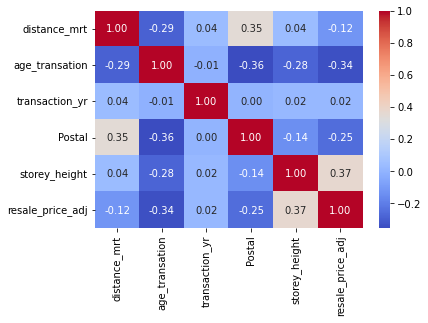

In [103]:
continuous_features = ['distance_mrt','age_transation','transaction_yr','Postal','storey_height', 'resale_price_adj']
g = sns.heatmap(df_chosen[continuous_features].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

None of the parameters have correlation of 1 to each other. This indicates that colinearity is not an issue.

In addition, transaction year has little effect on the resale adjusted price. This indicate the adjustment using resale price index was good.

In [104]:
#Create different columns for categorical values ['town', 'flatnum']
df_chosen = pd.get_dummies(df_chosen)
df_chosen.columns

Index(['distance_mrt', 'age_transation', 'transaction_yr', 'Postal',
       'storey_height', 'resale_price_adj', 'town_ANG MO KIO', 'town_BEDOK',
       'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'flat_num_1 ROOM', 'flat_num_2 ROOM', 'flat_num_3 ROOM',
       'flat_num_4 ROOM', 'flat_num_5 ROOM', 'flat_num_EXECUTIVE',
       'flat_num_MULTI-GENERATION'],
      dtype='object')

In [105]:
#Create train and test sets
model_data = df_chosen.copy()

X = model_data.drop('resale_price_adj', axis=1)
y = model_data['resale_price_adj']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Model Selection

In [106]:
models = [LinearRegression(), Ridge(), RandomForestRegressor(), GradientBoostingRegressor()]
for m in tqdm(models):
    model = make_pipeline(StandardScaler(),m)
    model.fit(X_train, y_train)  # apply scaling on training data
    print("="*100)
    print('For model', m)
    print('Model score is:', model.score(X_test, y_test))
    print('Mean Absolute Error:', mean_absolute_error(y_test, model.predict(X_test)))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, model.predict(X_test))))

<ipython-input-106-65a3d8006b88>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm(models):


  0%|          | 0/4 [00:00<?, ?it/s]

For model LinearRegression()
Model score is: 0.8360058821281908
Mean Absolute Error: 46080.041686465695
Root Mean Squared Error: 61774.962690243316
For model Ridge()
Model score is: 0.8360431187806779
Mean Absolute Error: 46085.84165664462
Root Mean Squared Error: 61767.948952679355
For model RandomForestRegressor()
Model score is: 0.965036377182583
Mean Absolute Error: 20070.72271779114
Root Mean Squared Error: 28523.74659199759
For model GradientBoostingRegressor()
Model score is: 0.888104879650156
Mean Absolute Error: 36041.20527731103
Root Mean Squared Error: 51027.45755111088


In [111]:
##Testing out decision trees with optimizing for depth
x_axis = []
y_axis = []
score = []

print('testing out decision tree, OneHot, normalized')
for i in range(20,35):
    dt = make_pipeline(StandardScaler(),DecisionTreeRegressor(max_depth=i,random_state=27))
    dt.fit(X_train,y_train)
    pred = dt.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,pred))
    # print('rmse for decision tree, OneHot, normalized:', rmse)
    x_axis.append(i)
    y_axis.append(rmse)
    score.append(dt.score(X_test, y_test))

min_rmse = min(y_axis)
min_depth = x_axis[y_axis.index(min_rmse)]
max_score = score[y_axis.index(min_rmse)]
print('rmse for decision tree, OneHot, normalized:', min_rmse, 'at depth =', min_depth, 'with r2 at', max_score)


testing out decision tree, OneHot, normalized
rmse for decision tree, OneHot, normalized: 35875.2564534136 at depth = 22 with r2 at 0.9446913171434533


So far the two best algorithms are the randomforest and decision tree algorihtms. Let us see the breakdown of contributions by each feature for both

In [112]:
#Decision tree model
dt = make_pipeline(StandardScaler(),DecisionTreeRegressor(max_depth=22,random_state=27))
dt.fit(X_train,y_train)
pred = dt.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,pred))
print('rmse for decision tree:', rmse)

#Randomforest model
model = make_pipeline(StandardScaler(),RandomForestRegressor())
model.fit(X_train, y_train) 
print('rmse for randomforest', np.sqrt(mean_squared_error(y_test, model.predict(X_test))))

rmse for decision tree: 35875.2564534136
rmse for randomforest 28585.350377580562


In [115]:

feature_importances = pd.DataFrame(dt.steps[1][1].feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
                                    
feature_importances

,importance
Postal,0.253615
flat_num_3 ROOM,0.247546
age_transation,0.140746
flat_num_EXECUTIVE,0.109272
flat_num_5 ROOM,0.077503
distance_mrt,0.042854
storey_height,0.029619
town_BISHAN,0.021664
flat_num_2 ROOM,0.016538
flat_num_4 ROOM,0.016329


In [116]:

feature_importances = pd.DataFrame(model.steps[1][1].feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

feature_importances

,importance
Postal,0.251268
flat_num_3 ROOM,0.245331
age_transation,0.141606
flat_num_EXECUTIVE,0.107722
flat_num_5 ROOM,0.077242
distance_mrt,0.045315
storey_height,0.028798
town_BISHAN,0.024051
flat_num_2 ROOM,0.017434
flat_num_4 ROOM,0.016259


In [118]:
# save the randomforest model to disk
import pickle
filename = 'model/finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
###Reload the randomforest model to try out on actual data###
